In [72]:
import numpy as np
import pandas as pd
from importlib import reload
from pylab import plt
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller

import utils; reload(utils)

<module 'utils' from '/Users/kizawamasakazu/projects/machine_learning/work/time_series/stock_price_prediction/n225/utils.py'>

In [78]:
# データを準備
from fracdiff import fdiff
df = pd.read_csv('N225.csv')

df = df[['Close']]

df['exp_mean'] = df['Close'].expanding().mean()
df['exp_std'] = df['Close'].expanding().std()

df['Close'] = (df['Close'] - df['exp_mean']) / df['exp_std']

df['frac_diff'] = fdiff(df['Close'], 0.4)

df['y'] = df['Close'].shift(-1)


In [90]:
import torch
import torch.nn as nn
import torch.optim as optimizers
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class MyDataset(Dataset):
    
    def __init__(self, X, y):
        assert X.shape[0] == y.shape[0]
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
seqlen = 60
batch_size = 64

Xs, ys = [], []
df = df.dropna()
X = df['frac_diff'].values
y = df['y'].values
for i in range(X.shape[0]-seqlen+1):
    Xs.append(X[i:i+seqlen].reshape(1, -1))
    ys.append(y[i+seqlen-1])

Xs = np.stack(Xs)
ys = np.stack(ys)
print(Xs.shape)

train_val_X, test_X, train_val_y, test_y = train_test_split(Xs, ys, test_size=0.2, shuffle=False)
train_X, val_X, train_y, val_y = train_test_split(train_val_X, train_val_y, test_size=0.2, shuffle=False)

train_dataset = MyDataset(train_X, train_y)
val_dataset = MyDataset(val_X, val_y)
test_dataset = MyDataset(test_X, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=1)

(14423, 1, 60)


In [80]:
# モデル定義
class CNN1d(nn.Module):
    
    def __init__(self, seqlen, n_filters = 64):
        super().__init__()
        cnn_output_size = int((int((seqlen - 10 + 1) / 2) - 5 + 1) / 2) * n_filters
        self.l1 = nn.Conv1d(1, n_filters, kernel_size=10)
        self.m1 = nn.MaxPool1d(kernel_size=2)
        self.a1 = nn.ReLU()
        self.l2 = nn.Conv1d(n_filters, n_filters, kernel_size=5)
        self.m2 = nn.MaxPool1d(kernel_size=2)
        self.a2 = nn.ReLU()
        self.f2 = nn.Flatten()
        self.l3 = nn.Linear(cnn_output_size, 1)
    
    def forward(self, x):
        x = self.l1(x)
        x = self.m1(x)
        x = self.a1(x)
        x = self.l2(x)
        x = self.m2(x)
        x = self.a2(x)
        x = self.f2(x)
        x = self.l3(x)
        return x
    
# test
model = CNN1d(seqlen=60)

epoch: 0, train loss: 4.893480480386643, val loss: 0.26816517976112664
epoch: 1, train loss: 0.5055656918812019, val loss: 0.1014759169484023
epoch: 2, train loss: 0.27103733931107854, val loss: 0.040651591360074235
epoch: 3, train loss: 0.20475761975467321, val loss: 0.023535975269624032
epoch: 4, train loss: 0.1825187500598986, val loss: 0.015475549291295465
epoch: 5, train loss: 0.176980598253067, val loss: 0.012179920933704125
epoch: 6, train loss: 0.17514383963316504, val loss: 0.01052324628471979
epoch: 7, train loss: 0.17422560413797328, val loss: 0.009523551779238915
epoch: 8, train loss: 0.17332438879748224, val loss: 0.008855975587266585
epoch: 9, train loss: 0.17259575178832165, val loss: 0.0083814911065474
epoch: 10, train loss: 0.17197639002552023, val loss: 0.00796767260260367
epoch: 11, train loss: 0.17129759621275298, val loss: 0.007674186423400897
epoch: 12, train loss: 0.17061856653162977, val loss: 0.007417388366775413
epoch: 13, train loss: 0.17003167533584929, val 

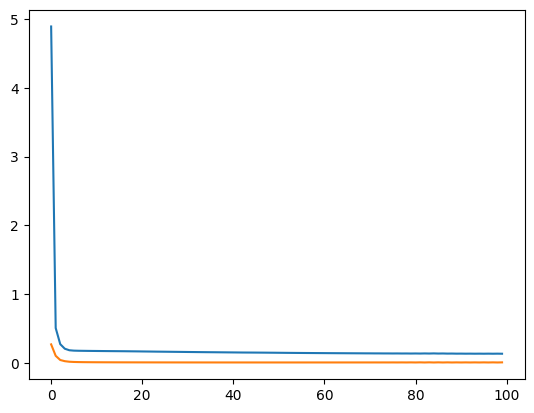

In [82]:
epochs = 100

model = CNN1d(seqlen=60)
criterion = nn.MSELoss()
optimizer = optimizers.Adam(model.parameters(), lr=0.0001)


def compute_loss(y, yhat):
    return criterion(yhat, y)

def train_step(x, y):
    model.train()
    yhat = model(x)
    loss = criterion(y, yhat)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return yhat, loss

def val_step(x, y):
    model.eval()
    yhat = model(x)
    loss = criterion(y, yhat)
    return yhat, loss


# 学習
history = {'train_loss': [], 'val_loss': []}
for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    for x, y in train_dataloader:
        _, loss = train_step(x, y)
        train_loss += loss.item()
    train_loss /= batch_size
    
    for x, y in val_dataloader:
        _, loss = val_step(x, y)
        val_loss += loss.item()
    val_loss /= batch_size # バッチ平均
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    print(f'epoch: {epoch}, train loss: {train_loss}, val loss: {val_loss}')
    
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')

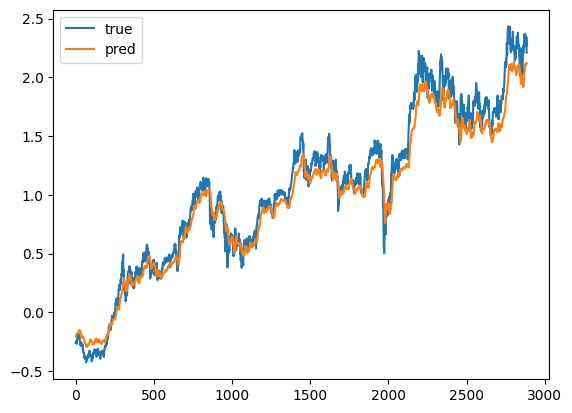

In [83]:
# 予測
model.eval()
ypreds = []
ys = []
for x, y in test_dataloader:
    ypred = model(x)
    ypreds.append(ypred.detach().flatten())
    ys.append(y.detach().flatten())
ypreds = torch.cat(ypreds)
ys = torch.cat(ys)

plt.plot(ys, label='true')
plt.plot(ypreds, label='pred')
plt.legend()

In [ ]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # TODO
        
    def forward(self, x):
        # TDOO
        pass

In [84]:
class LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=1):
        super().__init__()
        self.l1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.l2 = nn.Linear(hidden_size, output_size)
        
        nn.init.xavier_normal_(self.l1.weight_ih_l0)
        nn.init.orthogonal(self.l1.weight_hh_l0)
        
    def forward(self, x):
        h, _ = self.l1(x)
        y = self.l2(h[:,-1])
        return y

model = LSTM(input_size=1, hidden_size=64)
model(torch.randn(10, 60, 1))

/var/folders/sv/k4676nzx20ndpwkjt51ctv380000gn/T/ipykernel_50060/3073272558.py:9: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(self.l1.weight_hh_l0)


tensor([[-0.1105],
        [-0.0935],
        [-0.0792],
        [-0.1021],
        [-0.0811],
        [-0.1270],
        [-0.1088],
        [-0.0671],
        [-0.0812],
        [-0.0881]], grad_fn=<AddmmBackward0>)

/var/folders/sv/k4676nzx20ndpwkjt51ctv380000gn/T/ipykernel_50060/3073272558.py:9: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(self.l1.weight_hh_l0)
/Users/kizawamasakazu/.pyenv/versions/3.9.16/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/kizawamasakazu/.pyenv/versions/3.9.16/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14, 1])) that is different to the input size (torch.Size([14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/kizawamasakazu/.pyenv/version

epoch: 0, train loss: 8.364449760389107, val loss: 0.08159809075732483
epoch: 1, train loss: 3.553579639610689, val loss: 0.7331553194671869
epoch: 2, train loss: 2.70119712448286, val loss: 0.9711442482657731
epoch: 3, train loss: 2.4981291794974823, val loss: 0.6649748422205448
epoch: 4, train loss: 2.271841140347533, val loss: 0.31294105923734605
epoch: 5, train loss: 2.038143779103848, val loss: 0.16688176968455082
epoch: 6, train loss: 1.7834943779707828, val loss: 0.11275048470997717
epoch: 7, train loss: 1.5850274303302285, val loss: 0.1007517668804212
epoch: 8, train loss: 1.3636033975853934, val loss: 0.09275437811811571
epoch: 9, train loss: 1.1716624603977834, val loss: 0.08632152385689551
epoch: 10, train loss: 0.9849800781084923, val loss: 0.08627751989115495
epoch: 11, train loss: 0.7515482317103306, val loss: 0.08333231045980938
epoch: 12, train loss: 0.5283557778639079, val loss: 0.09147959905749303
epoch: 13, train loss: 0.36348265371998423, val loss: 0.094525834090745

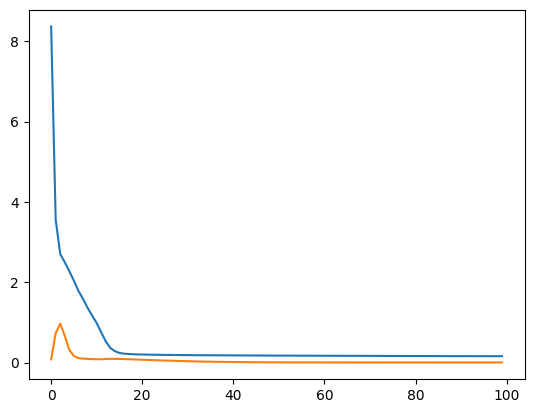

In [91]:
epochs = 100
batch_size = 64
model = LSTM(input_size=1, hidden_size=64, output_size=1)

criterion = nn.MSELoss()
optimizer = optimizers.Adam(model.parameters(), lr=0.0001)
    
history = {'train_loss': [], 'val_loss': []}
for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    for x, y in train_dataloader:
        x = x.permute(0, 2, 1) # seq, inp, chanに並べ替え
        _, loss = train_step(x, y)
        train_loss += loss.item()
    train_loss /= batch_size
    
    for x, y in val_dataloader:
        x = x.permute(0, 2, 1)
        _, loss = val_step(x, y)
        val_loss += loss.item()
    val_loss /= batch_size
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    print(f'epoch: {epoch}, train loss: {train_loss}, val loss: {val_loss}')
    
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])

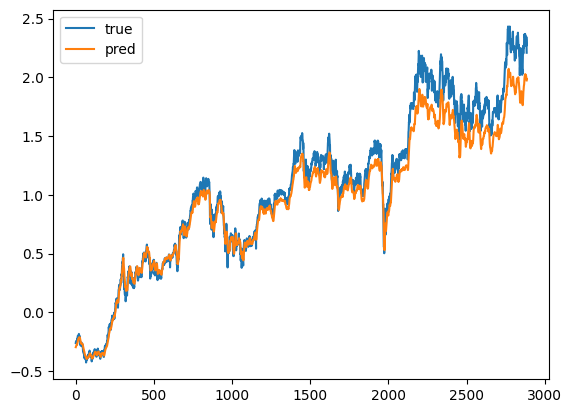

In [92]:
# 予測
model.eval()
ypreds = []
ys = []
for x, y in test_dataloader:
    x = x.permute(0, 2, 1)
    ypred = model(x)
    ypreds.append(ypred.detach().flatten())
    ys.append(y.detach().flatten())
ypreds = torch.cat(ypreds)
ys = torch.cat(ys)

plt.plot(ys, label='true')
plt.plot(ypreds, label='pred')
plt.legend()